# Introduction

In this paper we are gonna explore the Style Transfer article: [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The code is largely inspired by the udacity Deep Learning Course.

In [1]:
## Importing Section

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, models

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Device Selection

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Loading the model which will be used to extract style and content of the images

In [3]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
for name, layer in vgg._modules.items():
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

## Loading Image function and transform into tensor

In [5]:
def load_image(img_path, max_size = 400, shape = None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([transforms.Resize(size), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    # Next is to discard tha transparent channel in some images and adding batch_size to feed the network
    image = transform(image)[:3, :, :].unsqueeze(0)
    #print(image.size)
    return image

In [10]:
content = load_image('images/s.jpeg').to(device)
print(content.size())
style = load_image('images/renoir.jpeg', shape = content.shape[-2:]).to(device)
print(style.size())

torch.Size([1, 3, 400, 553])
torch.Size([1, 3, 400, 553])


## Converting the tensor image to numpy image

In [11]:
def im_converter(tensor):
    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0,1)
    
    return image

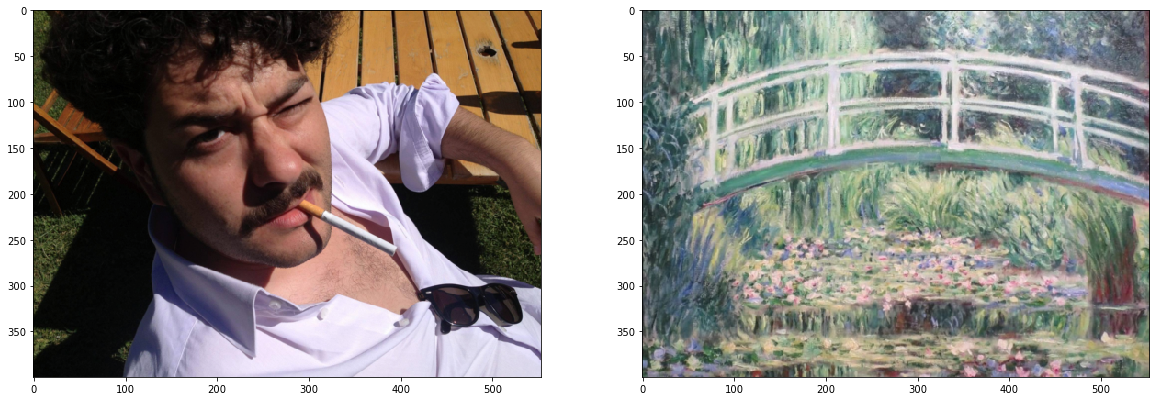

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(im_converter(content))
ax2.imshow(im_converter(style))

## Content and style features

In [13]:
def get_features(image, model, layers = None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in layers:
            features[layers[name]] = x
    
    return features

## Gram Matrix

Needed to compute the syle loss

In [14]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

## Here we extract content and style features, along with the results of gram matrix

They are needed to compute, pratically, the losses

In [15]:
## Content and style features

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [16]:
style_weights = {'conv1_1': 4.,
                 'conv2_1': 1,
                 'conv3_1': 3,
                 'conv4_1': 2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e1  # beta

## Training

Total loss:  485.2205505371094


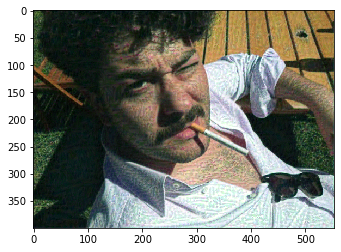

Total loss:  224.53692626953125


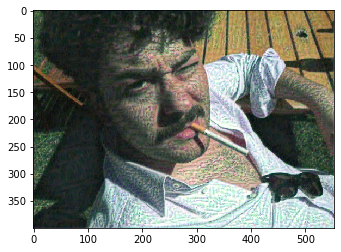

Total loss:  126.7183837890625


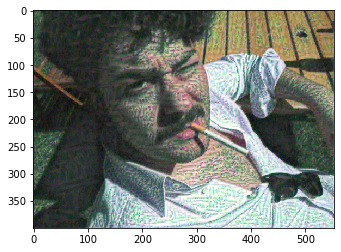

Total loss:  80.34925842285156


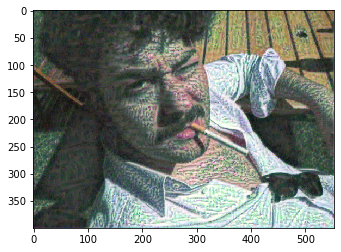

Total loss:  55.554962158203125


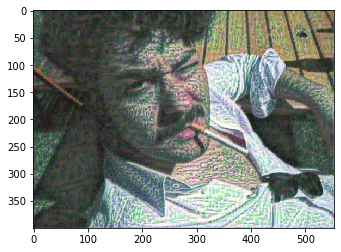

Total loss:  41.03002166748047


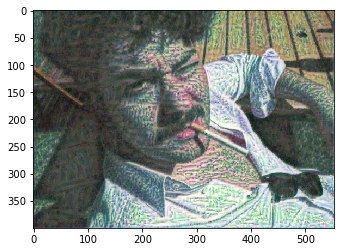

Total loss:  31.84737205505371


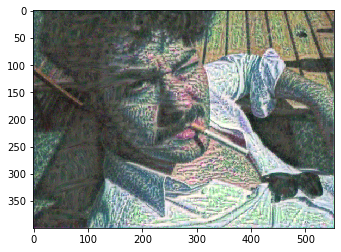

Total loss:  25.632389068603516


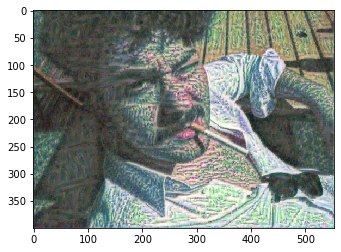

Total loss:  21.186281204223633


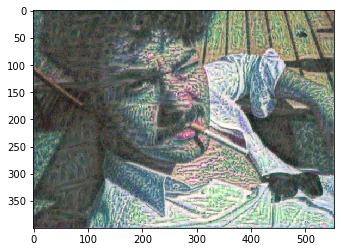

Total loss:  17.8876895904541


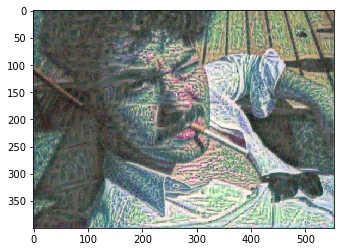

Total loss:  15.381391525268555


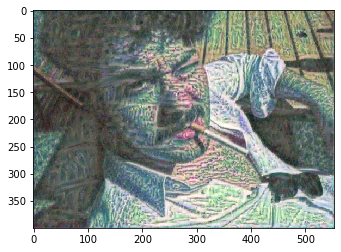

Total loss:  13.449482917785645


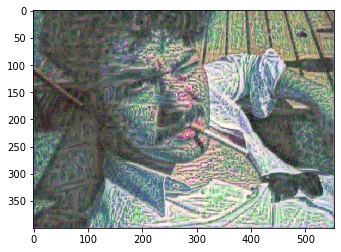

Total loss:  11.960596084594727


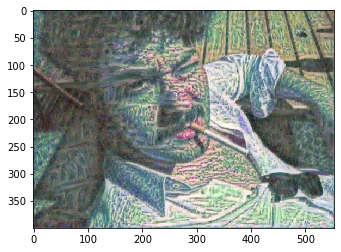

Total loss:  10.817687034606934


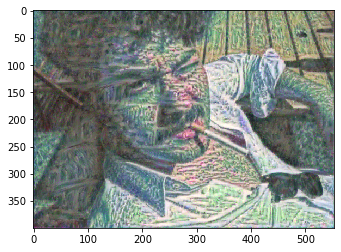

Total loss:  9.959000587463379


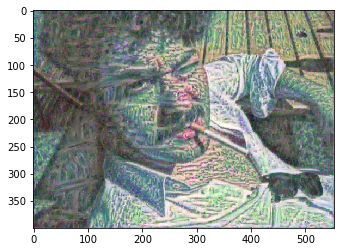

Total loss:  9.311548233032227


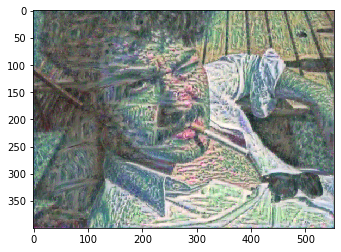

Total loss:  8.830240249633789


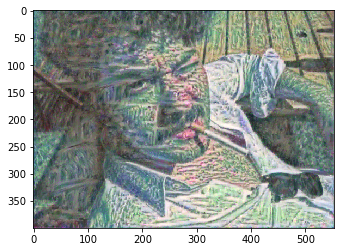

Total loss:  8.480062484741211


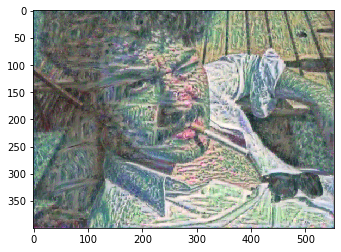

Total loss:  8.195049285888672


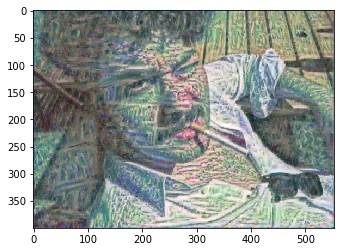

Total loss:  7.987711429595947


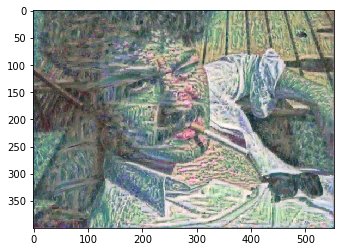

Total loss:  7.817388534545898


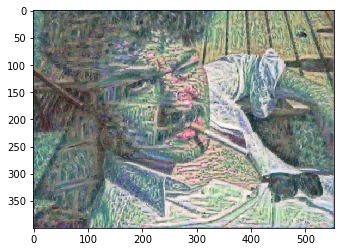

Total loss:  7.671445369720459


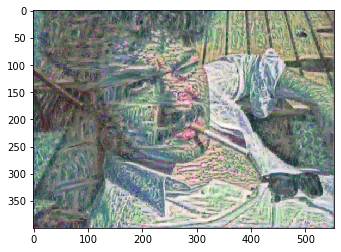

Total loss:  7.567722320556641


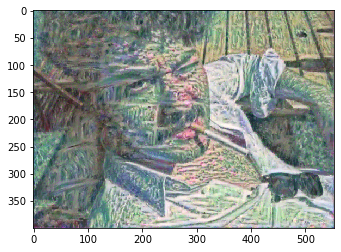

Total loss:  7.479731559753418


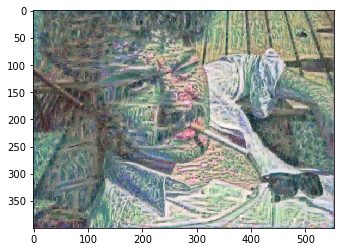

Total loss:  7.397499084472656


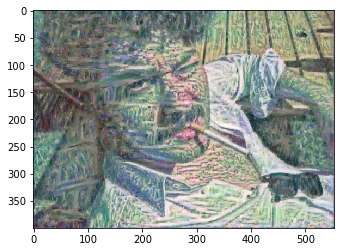

Total loss:  7.3351030349731445


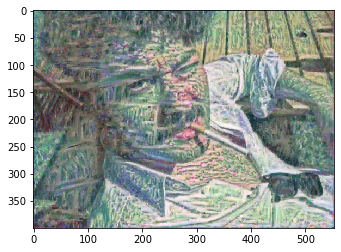

Total loss:  7.277773380279541


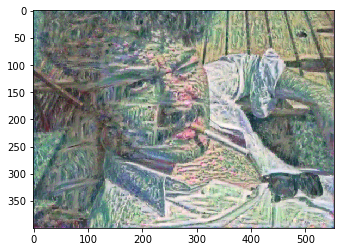

Total loss:  7.226104736328125


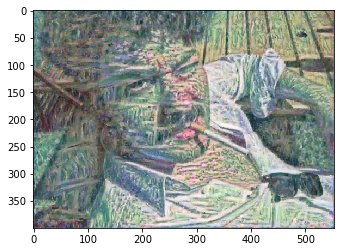

Total loss:  7.186090469360352


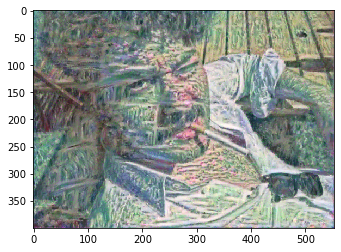

Total loss:  7.146933078765869


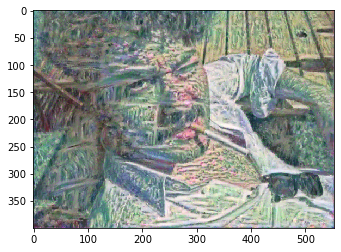

In [17]:
show_every = 400
optimizer = optim.Adam([target], lr=0.003)
steps = 12000

for step in range(1, steps + 1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  step % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_converter(target))
        plt.show()

In [18]:
image = im_converter(target)

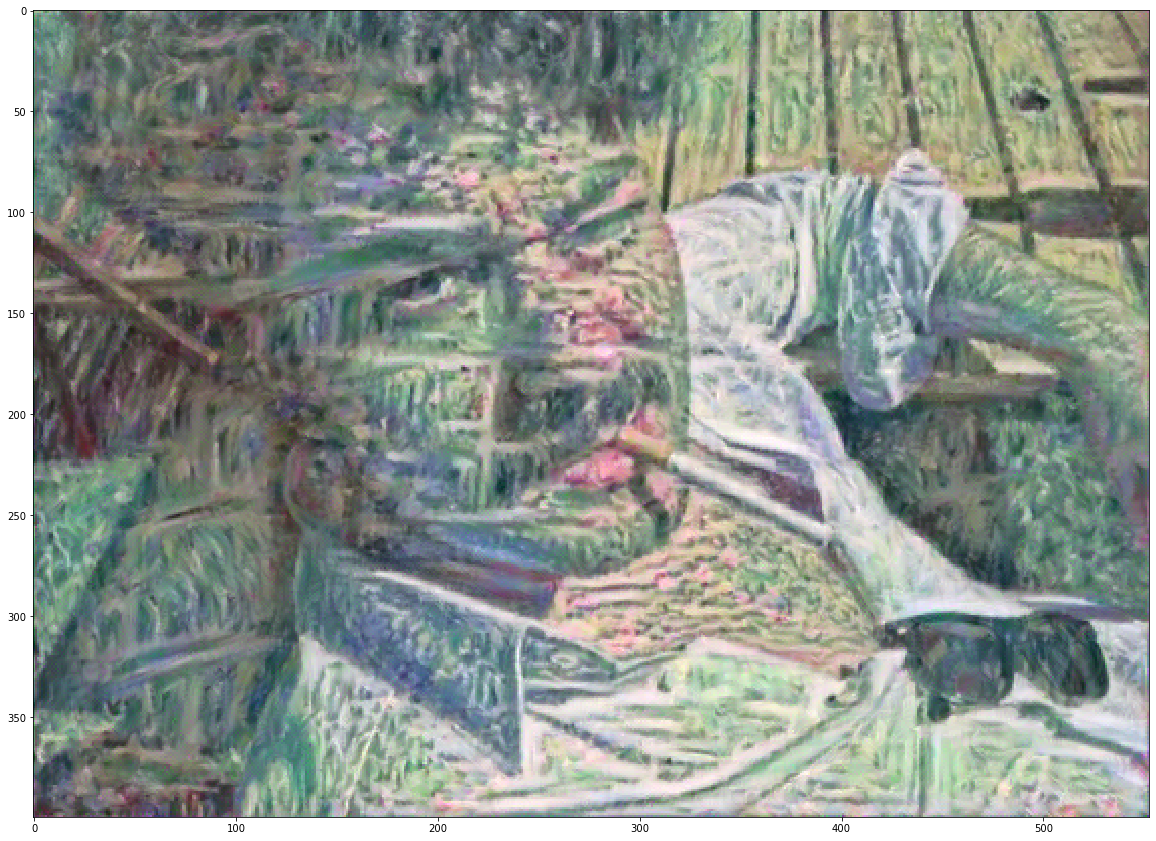

In [19]:
plt.figure(figsize = (20, 15))
plt.imshow(image)
plt.savefig('Sans_ren.png')